This notebook explores the [March Machine Learninig Mania 2022 - Men's ](https://www.kaggle.com/c/mens-march-mania-2022/data) dataset while paying special attention to the Regular Season Compact Results & NCAA Tournament Compact Results.

<center><img src="https://cdn.vox-cdn.com/thumbor/uK9Z479GcMiLoity3jBdxv3mzMo=/0x0:3000x2000/920x613/filters:focal(1264x809:1744x1289):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/63255145/zack_brackets_ringer.0.jpg" style="width:800px"><br>
<a href='https://www.theringer.com/2019/3/18/18270554/ncaa-tournament-bracket-tips'>The Ringer</a></center>



## [How are March Madness teams selected?](https://www.ncaa.com/news/basketball-men/mml-official-bracket/ncaa-bracket-printable-march-madness-bracket-pdf)
There are two ways that a team can earn a bid to the NCAA tournament: 
>The 32 Division I conferences all receive an **automatic bid** (there were 31 in 2021), which they each award to the team that **wins the postseason conference tournament**. Regardless of how a team performed during the regular season, if they are eligible for postseason play and win their conference tournament, they are selected to receive a bid to the NCAA tournament. These teams are known as automatic qualifiers.

>The second avenue for an invitation is an **at-large bid. The selection committee (more on them in a second) convenes on Selection Sunday, after all regular season and conference tournament games are played, and decides which 36 teams (37 in 2021) that are not automatic qualifiers have the pedigree to earn an invitation to the tournament. 

## EDA Approach
I'll be using a top-down EDA method, i.e., I will start off by showing a complete competition database entity relationship diagram. And then gradually dig deeper and deeper into understand how the "March Madness" historical data look like.

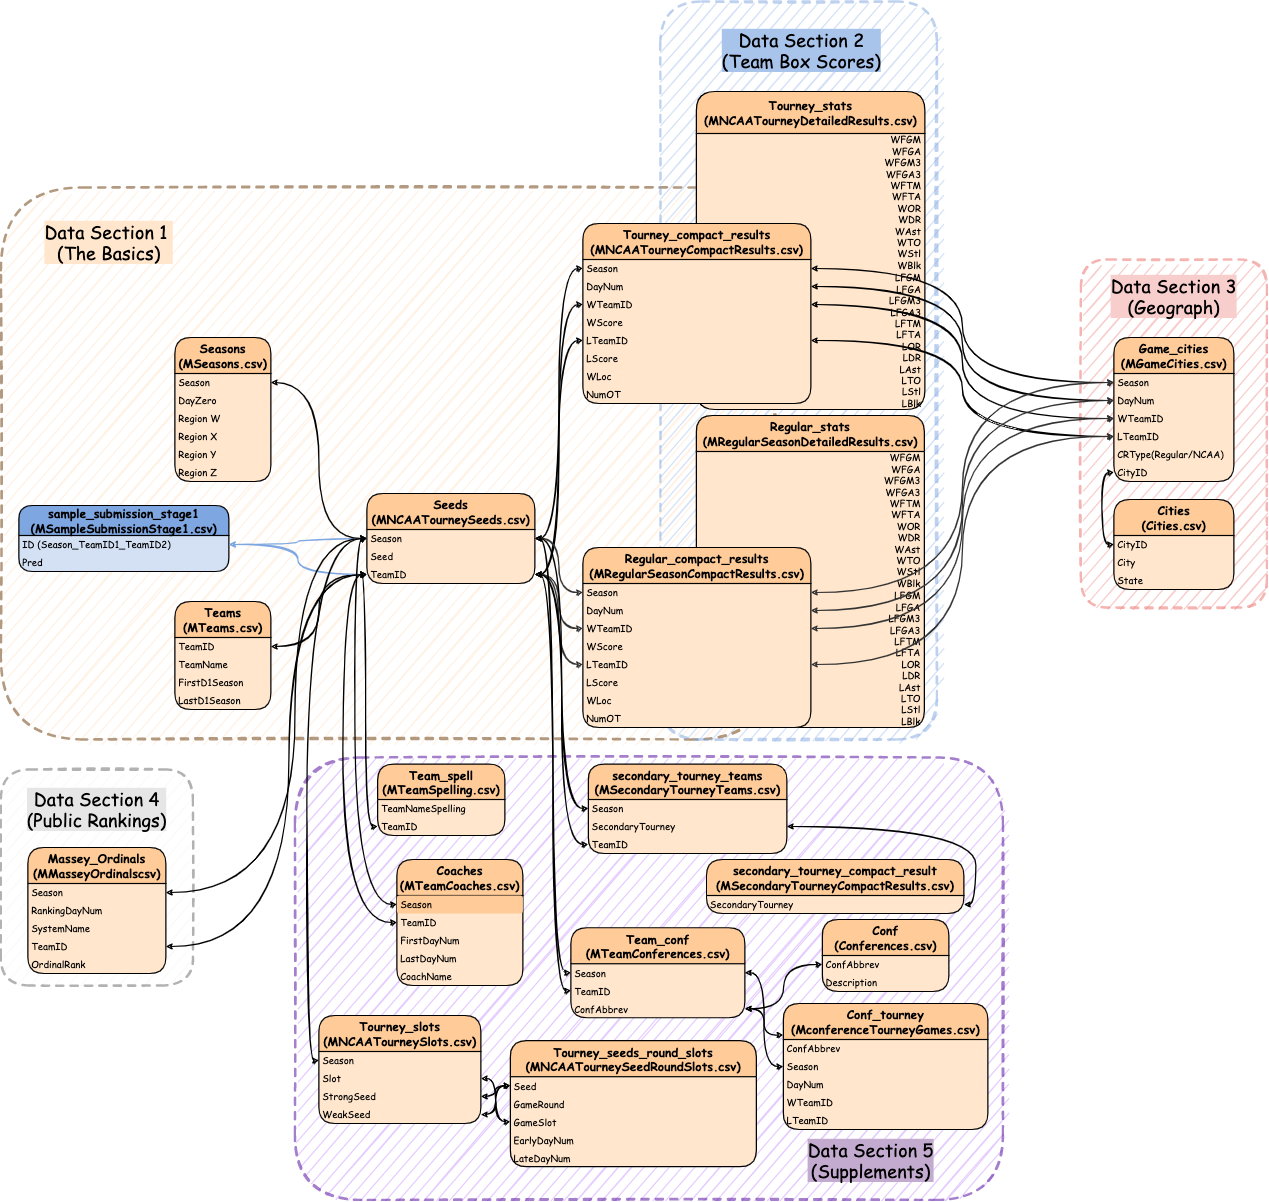

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(dplyr)) #data manipulaton
suppressMessages(library(caret))
suppressMessages(library(magrittr))
suppressMessages(library(data.table))
suppressMessages(library(gridExtra))
suppressMessages(library(randomForest))
suppressMessages(library(RANN))
suppressMessages(library(adabag))
suppressMessages(library(plyr))
if(!require(pacman)) install.packages("pacman")
suppressMessages(library(ggbump))


Loading required package: pacman



## Data Section 1 - The Basics

In [2]:
PATH="../input/mens-march-mania-2022/MDataFiles_Stage1/"

In [3]:
# read Data Section 1 files
# ----------------------------------------
# Sample submission for Stage1, i.e. the posssible matchup in the past 5 tournaments
sample_submission_stage1 <- read.csv(paste0(PATH,"MSampleSubmissionStage1.csv"))
# Tournament seeds since 1984-85 season
seeds<-read.csv(paste0(PATH,"MNCAATourneySeeds.csv"),stringsAsFactors = FALSE)
# Team ID's and Team Names
teams <- read.csv(paste0(PATH,"MTeams.csv"), stringsAsFactors = FALSE)
# Season-level details including dates and region names
seasons<-read.csv(paste0(PATH,"MSeasons.csv"),stringsAsFactors = FALSE)
# Final Scores of all regular season and NCAA tournament games since 1984-85
tourney_compact_results<- read.csv(paste0(PATH,"MNCAATourneyCompactResults.csv"),stringsAsFactors = FALSE)
regular_compacts <- read.csv(paste0(PATH,"MRegularSeasonCompactResults.csv"), stringsAsFactors = FALSE)

In [4]:
## Join the team names to tourney compact result dataset
tourney_compact_results<-tourney_compact_results %>% 
left_join(teams,by=c('WTeamID'='TeamID')) %>%
left_join(teams,by=c('LTeamID'='TeamID')) %>%
left_join(seeds,by=c('WTeamID'='TeamID','Season')) %>%
left_join(seeds,by=c('LTeamID'='TeamID','Season'))
tourney_compact_results<-dplyr::rename(tourney_compact_results, WTeamName=TeamName.x,LTeamName=TeamName.y, WSeed=Seed.x, LSeed=Seed.y)
tourney_compact_results$season_day <- paste(tourney_compact_results$Season, tourney_compact_results$DayNum, sep = "_")

#### Understand the meaning of "DayNum" in Tournament Table
 
According to the Competetion [Data Description](https://www.kaggle.com/c/ncaam-march-mania-2021/data), the values of **"DayNum"** represent the Tournament Round and will be consistent:
<table>
   <thead>
       <tr>
           <th>DayNum</th>
           <th>Meaning</th>
           <th>Description</th>
       </tr>
   </thead>
    <tbody>
        <tr>
        <td>134/135</td>
        <td>Round 0 </td>
         <td>play-in games</td>
        </tr>
        <tr>
        <td>136/137</td>
        <td>Round 1 </td>
         <td>64 -> 32</td>
        </tr>
        <tr>
        <td>138/139</td>
        <td>Round 2</td>
        <td>32 -> 16</td>
        </tr>
        <tr>
        <td>143/144</td>
        <td>Round 3</td>
        <td>16 ->  8 , "Sweet Sixteen"</td>
        </tr>
        <tr>
        <td>145/146</td>
        <td>Round 4</td>
        <td>8  ->  4 , "Elite Eight" , "Regional Finals"</td>
        </tr>
        <tr>
        <td>152</td>
        <td>Round 5</td>
        <td>4  ->  2 , "Final Four", "National Semifinals"</td>
        </tr>
        <tr>
        <td>154</td>
        <td>Round 6</td>
            <td>2  ->  1, "National Final", "National Championship"</td>
        </tr>
    </tbody>
</table>

Let's check the values of "DayNum" for each Season

In [5]:
# Let's check the values of "DayNum" for each Season
for (i in unique(tourney_compact_results$Season) ){
    cat(i,"--",unique(subset(tourney_compact_results,Season==i)$DayNum),'\n')
}

1985 -- 136 137 138 139 143 144 145 146 152 154 
1986 -- 136 137 138 139 143 144 145 146 152 154 
1987 -- 136 137 138 139 143 144 145 146 152 154 
1988 -- 136 137 138 139 143 144 145 146 152 154 
1989 -- 136 137 138 139 143 144 145 146 152 154 
1990 -- 136 137 138 139 143 144 145 146 152 154 
1991 -- 136 137 138 139 143 144 145 146 152 154 
1992 -- 136 137 138 139 143 144 145 146 152 154 
1993 -- 136 137 138 139 143 144 145 146 152 154 
1994 -- 136 137 138 139 143 144 145 146 152 154 
1995 -- 136 137 138 139 143 144 145 146 152 154 
1996 -- 136 137 138 139 143 144 145 146 152 154 
1997 -- 136 137 138 139 143 144 145 146 152 154 
1998 -- 136 137 138 139 143 144 145 146 152 154 
1999 -- 136 137 138 139 143 144 145 146 152 154 
2000 -- 136 137 138 139 143 144 145 146 152 154 
2001 -- 134 136 137 138 139 143 144 145 146 152 154 
2002 -- 134 136 137 138 139 143 144 145 146 152 154 
2003 -- 134 136 137 138 139 143 144 145 146 152 154 
2004 -- 134 136 137 138 139 143 144 145 146 152 154 
2005

We noticed the values of **"DayNum"** for Season 2021 has been shift, and the corresponding values of **"DayNum"** will be:
<table>
   <thead>
       <tr>
           <th>2021_DayNum</th>
           <th>Matched DayNum</th>
           <th>Meaning</th>
       </tr>
   </thead>
    <tbody>
        <tr>
        <td>136</td>
        <td>134/135</td>
        <td>Round 0 </td>
        </tr>
        <tr>
        <td>137/138</td>
        <td>136/137</td>
        <td>Round 1 </td>
        </tr>
        <tr>
        <td>139/140</td>
        <td>138/139</td>
        <td>Round 2</td>
        </tr>
        <tr>
        <td>145/146</td>
        <td>143/144</td>
        <td>Round 3</td>
        </tr>
        <tr>
        <td>147/148</td>
        <td>145/146</td>
        <td>Round 4</td>
        </tr>
        <tr>
        <td>152</td>    
        <td>152</td>
        <td>Round 5</td>
        </tr>
        <tr>
        <td>154</td>
        <td>154</td>
        <td>Round 6</td>
        </tr>
    </tbody>
</table>

Create a new column "Tourney Round" according to the values of "DayNum"

In [6]:
# Create a new column "Tourney Round" according to the values of "DayNum"
tourney_compact_results <- tourney_compact_results %>%
  mutate(TourneyRound = ifelse(Season==2021& DayNum %in% c(136), "Round 0",
                        ifelse(Season==2021& DayNum %in% c(137, 138), "Round 1",
                        ifelse(Season==2021& DayNum %in% c(139, 140), "Round 2", 
                        ifelse(Season==2021& DayNum %in% c(145, 146), "Round 3", 
                        ifelse(Season==2021& DayNum %in% c(147, 148), "Round 4",
                        ifelse(Season!=2021& DayNum %in% c(134, 135), "Round 0",
                        ifelse(Season!=2021& DayNum %in% c(136, 137), "Round 1",
                        ifelse(Season!=2021& DayNum %in% c(138, 139), "Round 2", 
                        ifelse(Season!=2021& DayNum %in% c(143, 144), "Round 3", 
                        ifelse(Season!=2021& DayNum %in% c(145, 146), "Round 4", 
                        ifelse(DayNum == 152, "Round 5" ,"Round 6"))))))))))))%>%
  mutate(TourneyRound = factor(TourneyRound, levels = c("Round 0","Round 1", "Round 2", "Round 3", "Round 4", "Round 5", "Round 6")))

In [7]:
#head(seasons)

In [8]:
tourney_compact_results<-tourney_compact_results%>%rowwise()%>%do(data.frame(.,Region=case_when(substr(.$WSeed,1,1)=='X' ~ subset(seasons,Season==.$Season)$RegionX,
                                                 substr(.$WSeed,1,1)=='W' ~ subset(seasons,Season==.$Season)$RegionW,
                                                 substr(.$WSeed,1,1)=='Y' ~ subset(seasons,Season==.$Season)$RegionY,
                                                 substr(.$WSeed,1,1)=='Z' ~ subset(seasons,Season==.$Season)$RegionZ)))
tourney_compact_results <- tourney_compact_results %>%
                            mutate(Region_code=substr(tourney_compact_results$WSeed,1,1))%>%
                            mutate(Seed_num=substr(tourney_compact_results$WSeed,2,3))

In [9]:
# create subset contains the historical teams information for each round of each season
round_6_stats<-subset(tourney_compact_results,TourneyRound=='Round 6')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_5_stats<-subset(tourney_compact_results,TourneyRound=='Round 5')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_4_stats<-subset(tourney_compact_results,TourneyRound=='Round 4')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_3_stats<-subset(tourney_compact_results,TourneyRound=='Round 3')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_2_stats<-subset(tourney_compact_results,TourneyRound=='Round 2')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_1_stats<-subset(tourney_compact_results,TourneyRound=='Round 1')%>%dplyr::select("Season","WTeamName",'TourneyRound','WSeed','Region','Region_code','Seed_num')
round_0_stats<-subset(tourney_compact_results,TourneyRound=='Round 0')%>%dplyr::select("Season","LTeamName",'TourneyRound','LSeed','Region','Region_code','Seed_num')%>%
                dplyr::rename(Season=Season,WTeamName=LTeamName,TourneyRound=TourneyRound,WSeed=LSeed)%>%bind_rows(round_1_stats)%>%arrange(Season)

In [10]:
#subset(round_5_stats$Region_code,round_6_stats$WTeamName=='Duke')

### How are regions determined in NCAA Tournament?
We noticed that the regions of each team for each season are not consistent, and why is that?

>According to the [NCAA](https://www.ncaa.com/news/basketball-men/article/2021-03-14/ncaa-bracket-s-curve-explained), 
> * Each of the **top four teams selected from a conference** shall be placed in different regions if they are seeded on the first four lines.
>* Teams from the same conference shall not meet before the regional final if they played each other three or more times during the regular season, to include the conference tournament.
>* Teams from the same conference shall not meet before the regional semifinals if they played each other twice during the regular season, to include the conference tournament.
>* Teams from the same conference may play each other as early as the second round if they played no more than once during the regular season, to include the conference tournament.
>* If possible, rematches of nonconference regular-season games should be avoided in the First Four and first round.

Simply put, I will not include region information in the following analysis at this point.

### Let's plot the histgram graphs for each tournament round

In [11]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kentucky','Louisville','Kansas','Florida')

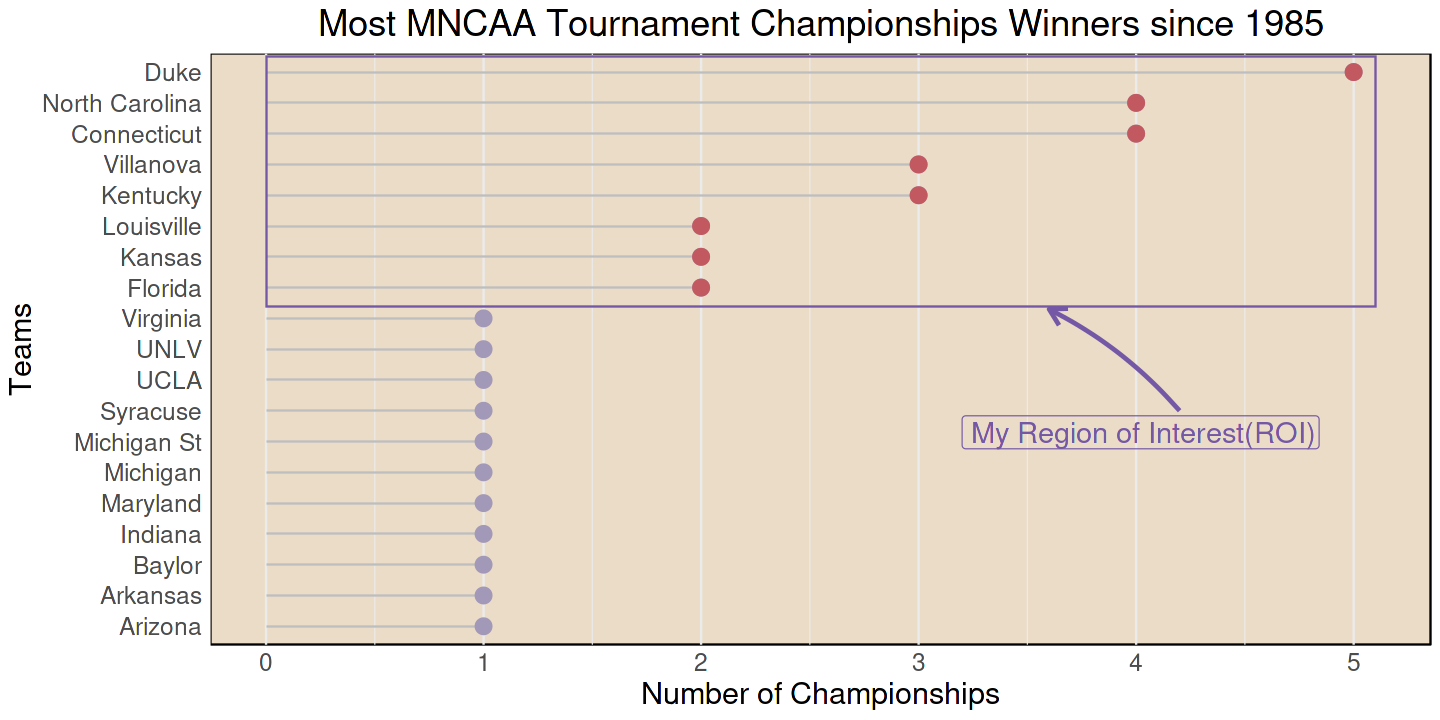

In [12]:
options(repr.plot.width=12, repr.plot.height=6)

round_6_stats_plot<-round_6_stats %>% 
    group_by(WTeamName)%>%
    dplyr::summarise(n=n())
highlight_team_6<-subset(round_6_stats_plot,WTeamName %in% highlight_list)

round_6_stats_plot%>% ggplot(aes(x=reorder(WTeamName,n),y=n)) +
    geom_segment( aes(x=reorder(WTeamName,n),xend=reorder(WTeamName,n), y=0, yend=n), color="grey") +
    geom_point(size=4, color="#a298b8") +
    geom_point(data=highlight_team_6,size=4, color="#c25960") +
    theme_minimal()+
    theme(text = element_text(size = 18),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Most MNCAA Tournament Championships Winners since 1985", x= "Teams", y= "Number of Championships")+
    coord_flip()+
  annotate("rect", xmin = 11.4, xmax = 19.5,  ymin = 0, ymax = 5.1,fill=NA, colour="#7458a6", alpha=0.3)+
   annotate(
    geom = "curve", xend = 11.3, yend = 3.6, x = 8, y = 4.2, color="#7458a6",size=1,
    curvature = .1, arrow = arrow(length = unit(4, "mm"))
  ) +
annotate(geom = "label", x = 7.3, y = 3.2, label = "My Region of Interest(ROI)", size=6,hjust = "left",fill=NA,color="#7458a6")

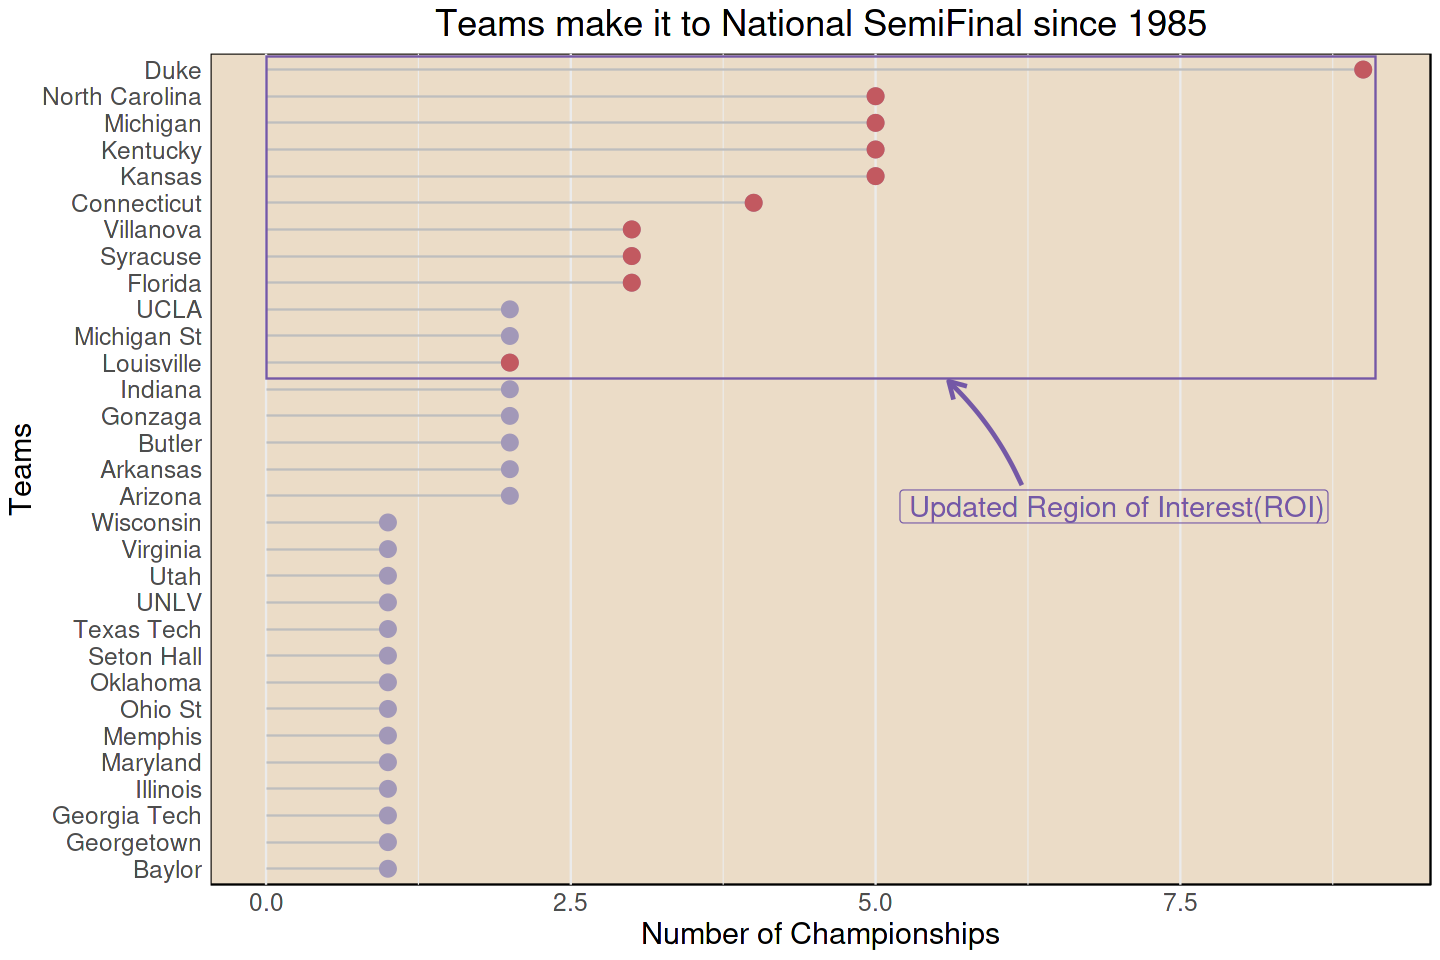

In [13]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kentucky','Louisville','Kansas','Florida','Michigan','Syracuse')
options(repr.plot.width=12, repr.plot.height=8)
round_5_stats_plot<-round_5_stats %>% 
    group_by(WTeamName)%>%
    dplyr::summarise(n=n())
highlight_team_5<-subset(round_5_stats_plot,WTeamName %in% highlight_list)

round_5_stats_plot%>% ggplot(aes(x=reorder(WTeamName,n),y=n)) +
    geom_segment( aes(x=reorder(WTeamName,n),xend=reorder(WTeamName,n), y=0, yend=n), color="grey") +
    geom_point(size=4, color="#a298b8") +
    geom_point(data=highlight_team_5,size=4, color="#c25960") +
    theme_minimal()+
    theme(text = element_text(size = 18),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Teams make it to National SemiFinal since 1985", x= "Teams", y= "Number of Championships")+
    coord_flip()+
annotate("rect", xmin = 19.4, xmax = 31.5,  ymin = 0, ymax = 9.1,fill=NA, colour="#7458a6", alpha=0.2)+
   annotate(
    geom = "curve", xend = 19.3, yend = 5.6, x = 15.4, y = 6.2, color="#7458a6",size=1,
    curvature = .1, arrow = arrow(length = unit(4, "mm"))
  ) +
annotate(geom = "label", x = 14.6, y = 5.2, label = "Updated Region of Interest(ROI)", size=6,hjust = "left",fill=NA,color="#7458a6")


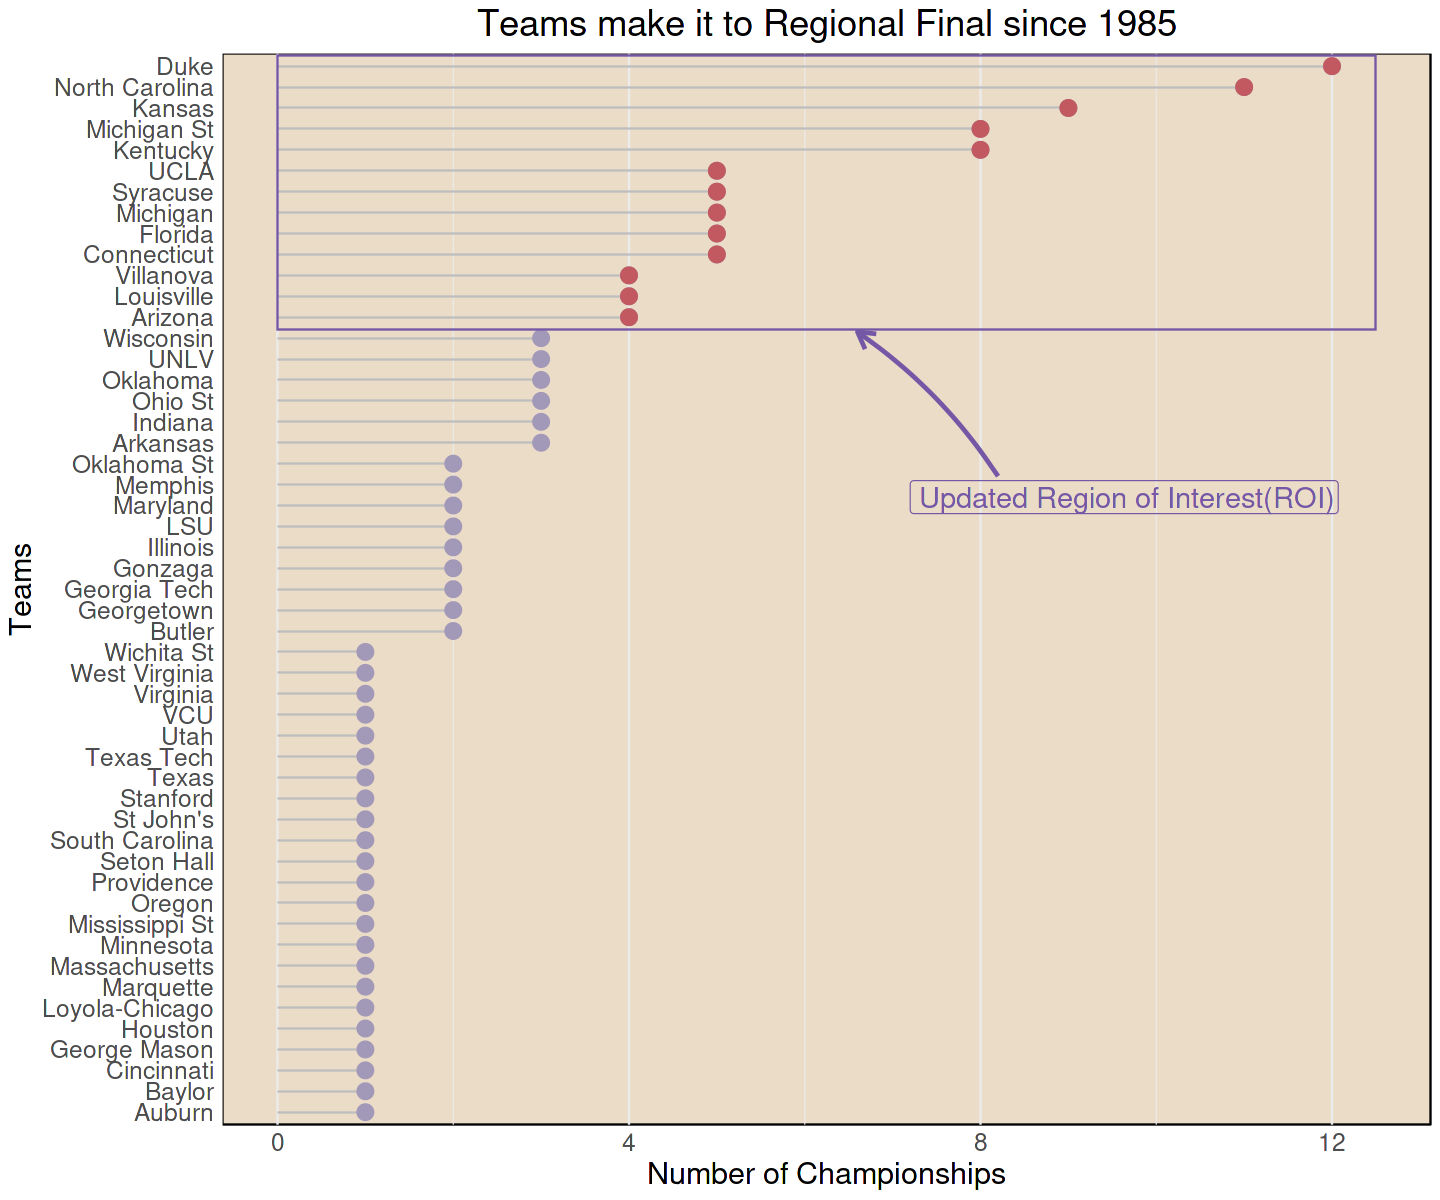

In [14]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kentucky','Louisville','Kansas','Florida','Michigan','Michigan St','UCLA','Arizona','Syracuse')

options(repr.plot.width=12, repr.plot.height=10)
round_4_stats_plot<-round_4_stats %>% 
    group_by(WTeamName)%>%
    dplyr::summarise(n=n())
highlight_team_4<-subset(round_4_stats_plot,WTeamName %in% highlight_list)

round_4_stats_plot%>% ggplot(aes(x=reorder(WTeamName,n),y=n)) +
    geom_segment( aes(x=reorder(WTeamName,n),xend=reorder(WTeamName,n), y=0, yend=n), color="grey") +
    geom_point(size=4, color="#a298b8") +
    geom_point(data=highlight_team_4,size=4, color="#c25960") +
    theme_minimal()+
    theme(text = element_text(size = 18),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Teams make it to Regional Final since 1985", x= "Teams", y= "Number of Championships")+
    coord_flip()+
annotate("rect", xmin = 38.4, xmax = 51.5,  ymin = 0, ymax = 12.5,fill=NA, colour="#7458a6", alpha=0.2)+
   annotate(
    geom = "curve", xend = 38.3, yend = 6.6, x = 31.4, y = 8.2, color="#7458a6",size=1,
    curvature = .1, arrow = arrow(length = unit(4, "mm"))
  ) +
annotate(geom = "label", x = 30.4, y = 7.2, label = "Updated Region of Interest(ROI)", size=6,hjust = "left",fill=NA,color="#7458a6")



In [15]:
#round_3_stats_plot%>%arrange(desc(n))%>%head(16)

# round_2_stats_plot<-round_2_stats%>%
#     group_by(WTeamName)%>%
#     dplyr::summarise(n=n())
# round_2_stats_plot%>%arrange(desc(n))%>%head(32)

# round_1_stats_plot<-round_1_stats%>%
#     group_by(WTeamName)%>%
#     dplyr::summarise(n=n())
# round_1_stats_plot%>%arrange(desc(n))%>%head(64)


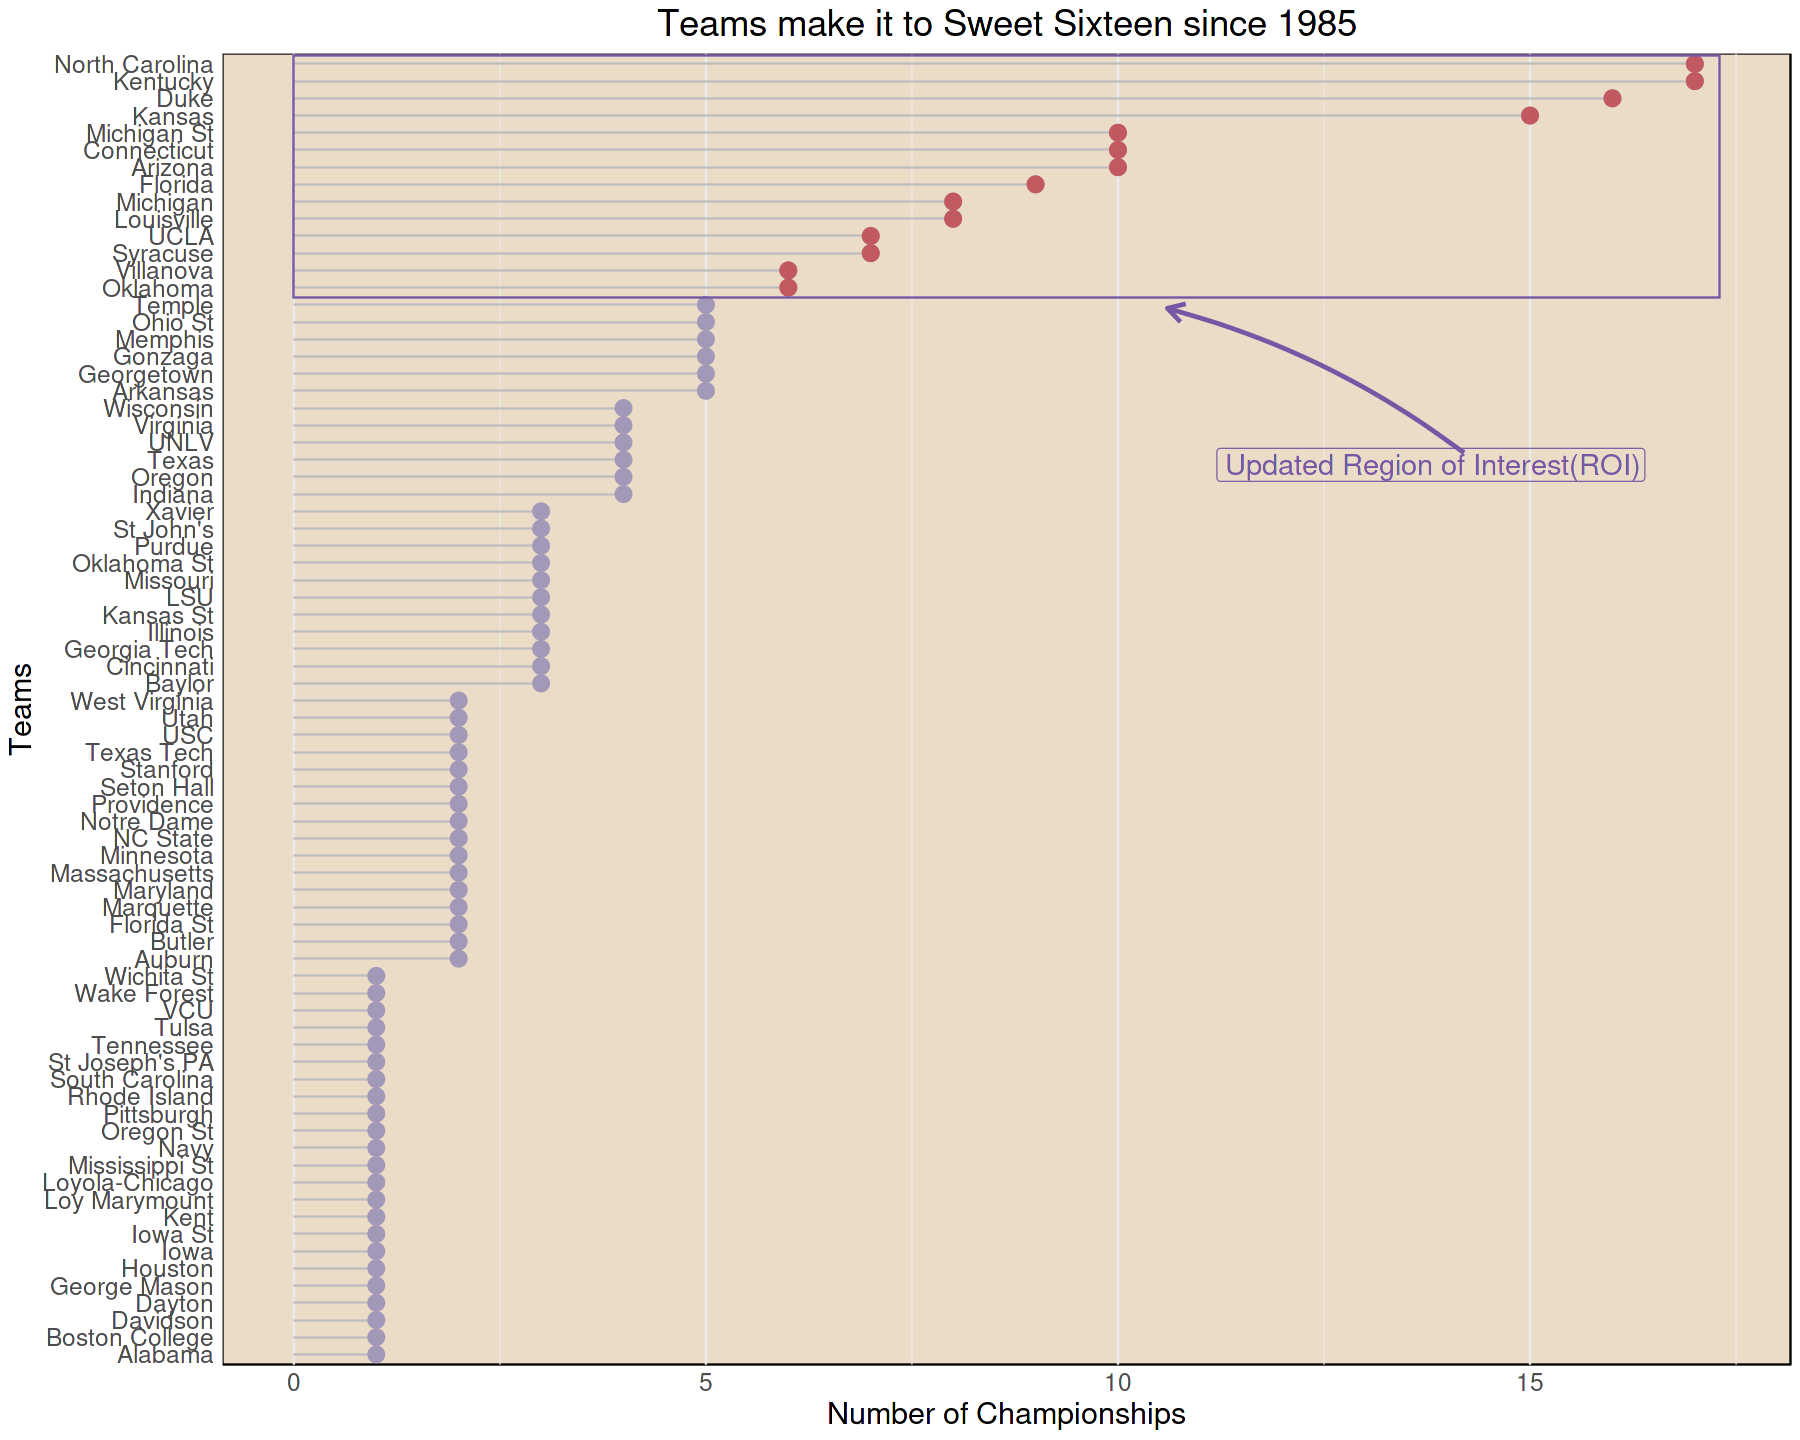

In [16]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kentucky','Louisville','Kansas','Florida','Michigan','Michigan St','UCLA','Arizona','Syracuse','Oklahoma')

options(repr.plot.width=15, repr.plot.height=12)
round_3_stats_plot<-round_3_stats %>% 
    group_by(WTeamName)%>%
    dplyr::summarise(n=n())
highlight_team_3<-subset(round_3_stats_plot,WTeamName %in% highlight_list)

round_3_stats_plot%>% ggplot(aes(x=reorder(WTeamName,n),y=n)) +
    geom_segment( aes(x=reorder(WTeamName,n),xend=reorder(WTeamName,n), y=0, yend=n), color="grey") +
    geom_point(size=4, color="#a298b8") +
    geom_point(data=highlight_team_3,size=4, color="#c25960") +
    theme_minimal()+
    theme(text = element_text(size = 18),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Teams make it to Sweet Sixteen since 1985", x= "Teams", y= "Number of Championships")+
    coord_flip()+
annotate("rect", xmin = 62.4, xmax = 76.5,  ymin = 0, ymax = 17.3,fill=NA, colour="#7458a6", alpha=0.2)+
   annotate(
    geom = "curve", xend = 61.8, yend = 10.6, x = 53.4, y = 14.2, color="#7458a6",size=1,
    curvature = .1, arrow = arrow(length = unit(4, "mm"))
  ) +
annotate(geom = "label", x = 52.7, y = 11.2, label = "Updated Region of Interest(ROI)", size=6,hjust = "left",fill=NA,color="#7458a6")



#### Let's use Bump Chart to explore my ROI teams' performance spanning the seasons .

In [17]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kansas','Virginia','Baylor')
ROI_sub<-subset(tourney_compact_results,WTeamName %in% highlight_list)%>%
    group_by(Season,WTeamName)%>%
    filter(DayNum == max(DayNum, na.rm=TRUE))%>%
    mutate(Round = ifelse(TourneyRound=="Round 0",0,
                  ifelse(TourneyRound=="Round 1",1,
                  ifelse(TourneyRound=="Round 2",2,
                  ifelse(TourneyRound=="Round 3",3,
                  ifelse(TourneyRound=="Round 4",4,
                  ifelse(TourneyRound=="Round 5",5,6)))))))

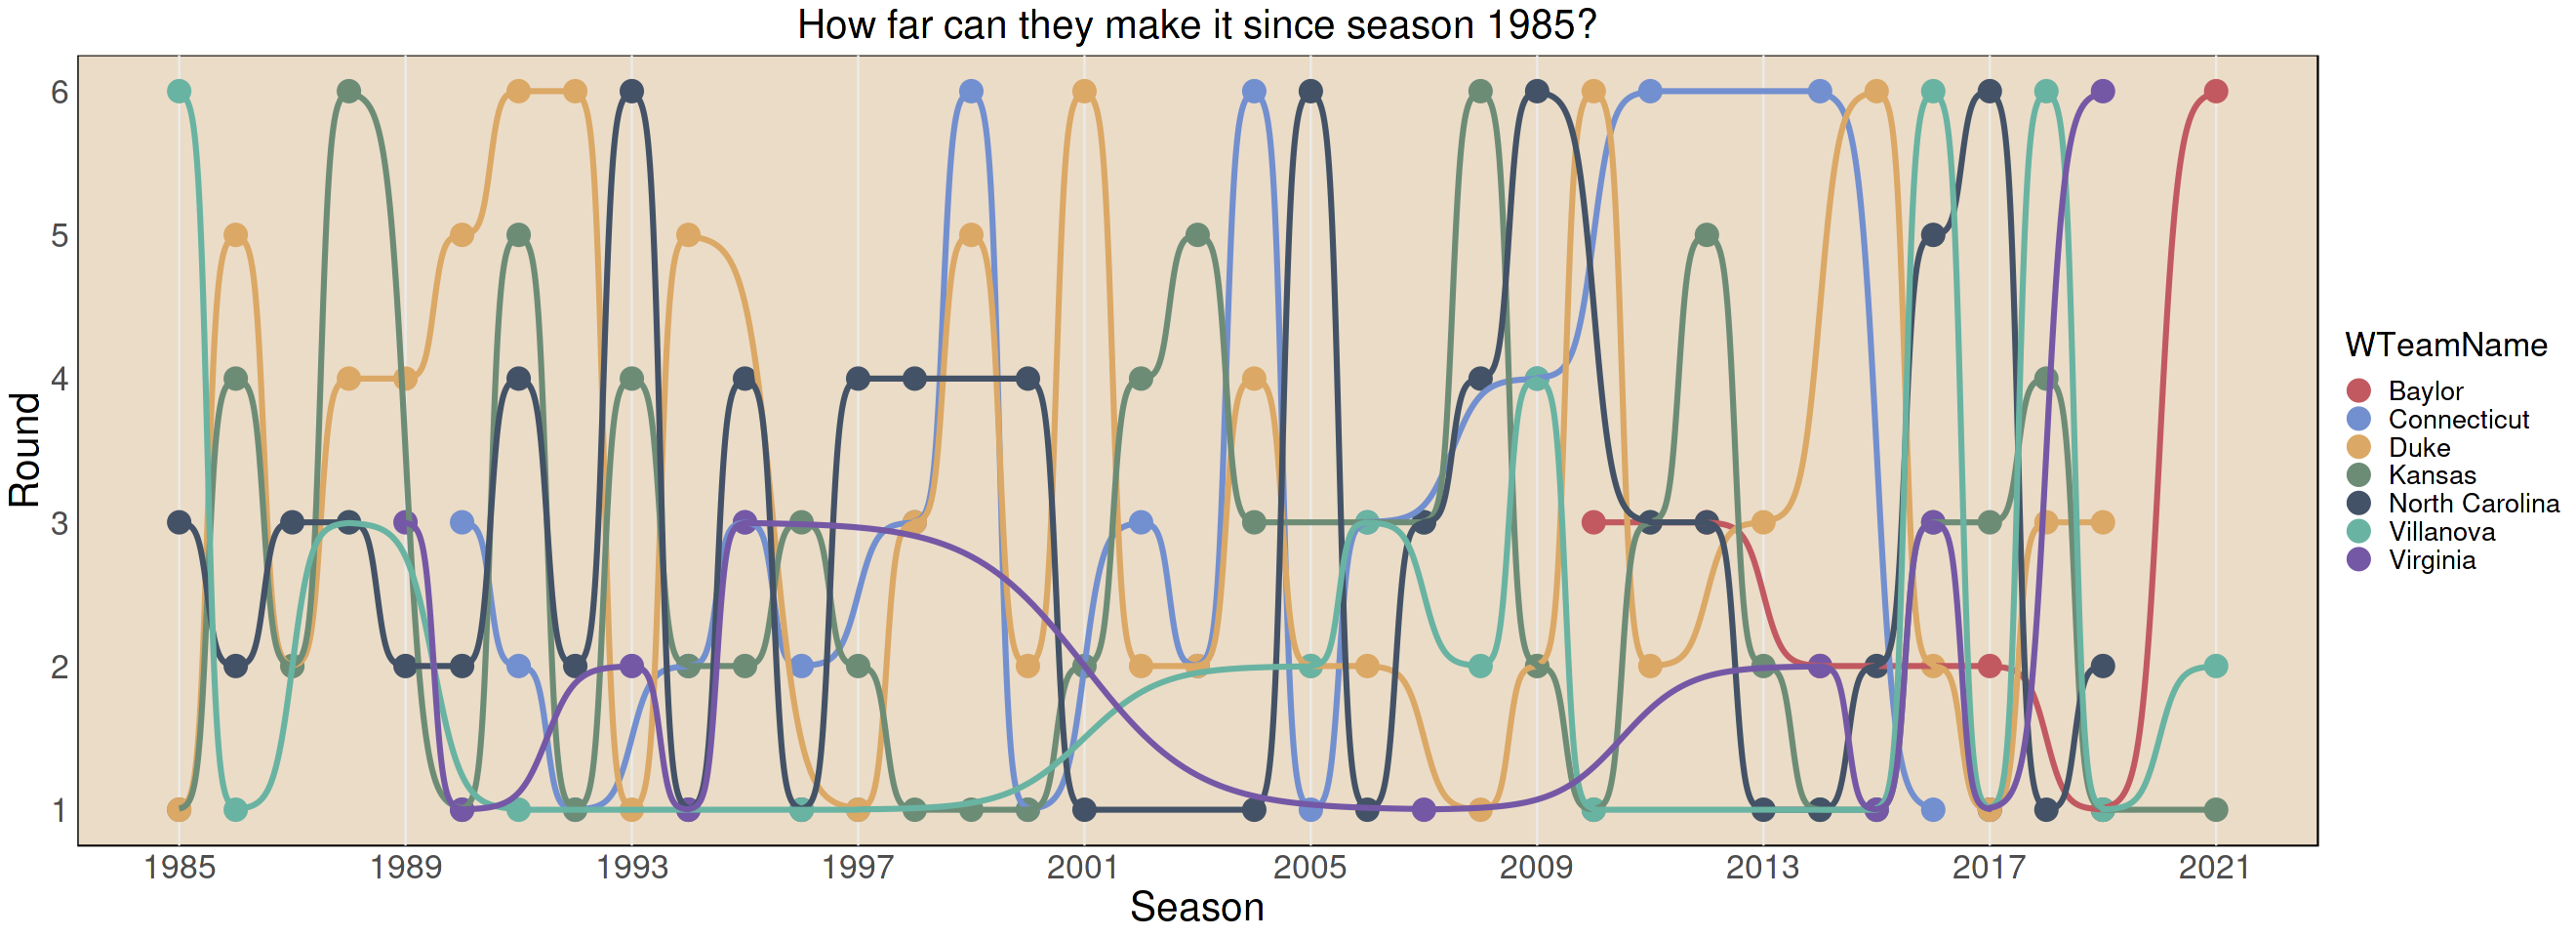

In [18]:
options(repr.plot.width=22, repr.plot.height=8)

ggplot(ROI_sub, aes(Season, Round, color = WTeamName)) +
    geom_point(size = 6) +
    geom_bump(size = 1.3, smooth = 6)+
    scale_x_continuous(limits = c(1985, 2021),
                        breaks = seq(1985, 2021, 4)) +
    scale_y_continuous(limits = c(1,6),
                        breaks = seq(1, 6, 1)) +
    theme_minimal()+
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5),
          panel.background = element_rect(fill="#ebdcc7"),
          axis.text=element_text(size=20),
          axis.title=element_text(size=24),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.y = element_blank()
          )+
    labs(title = "How far can they make it since season 1985?")+
scale_color_manual(values = c("#c25960","#728fcf","#dba865","#6d8c76","#435266","#69b3a2","#7458a6"))

### Does Seed Number matter?

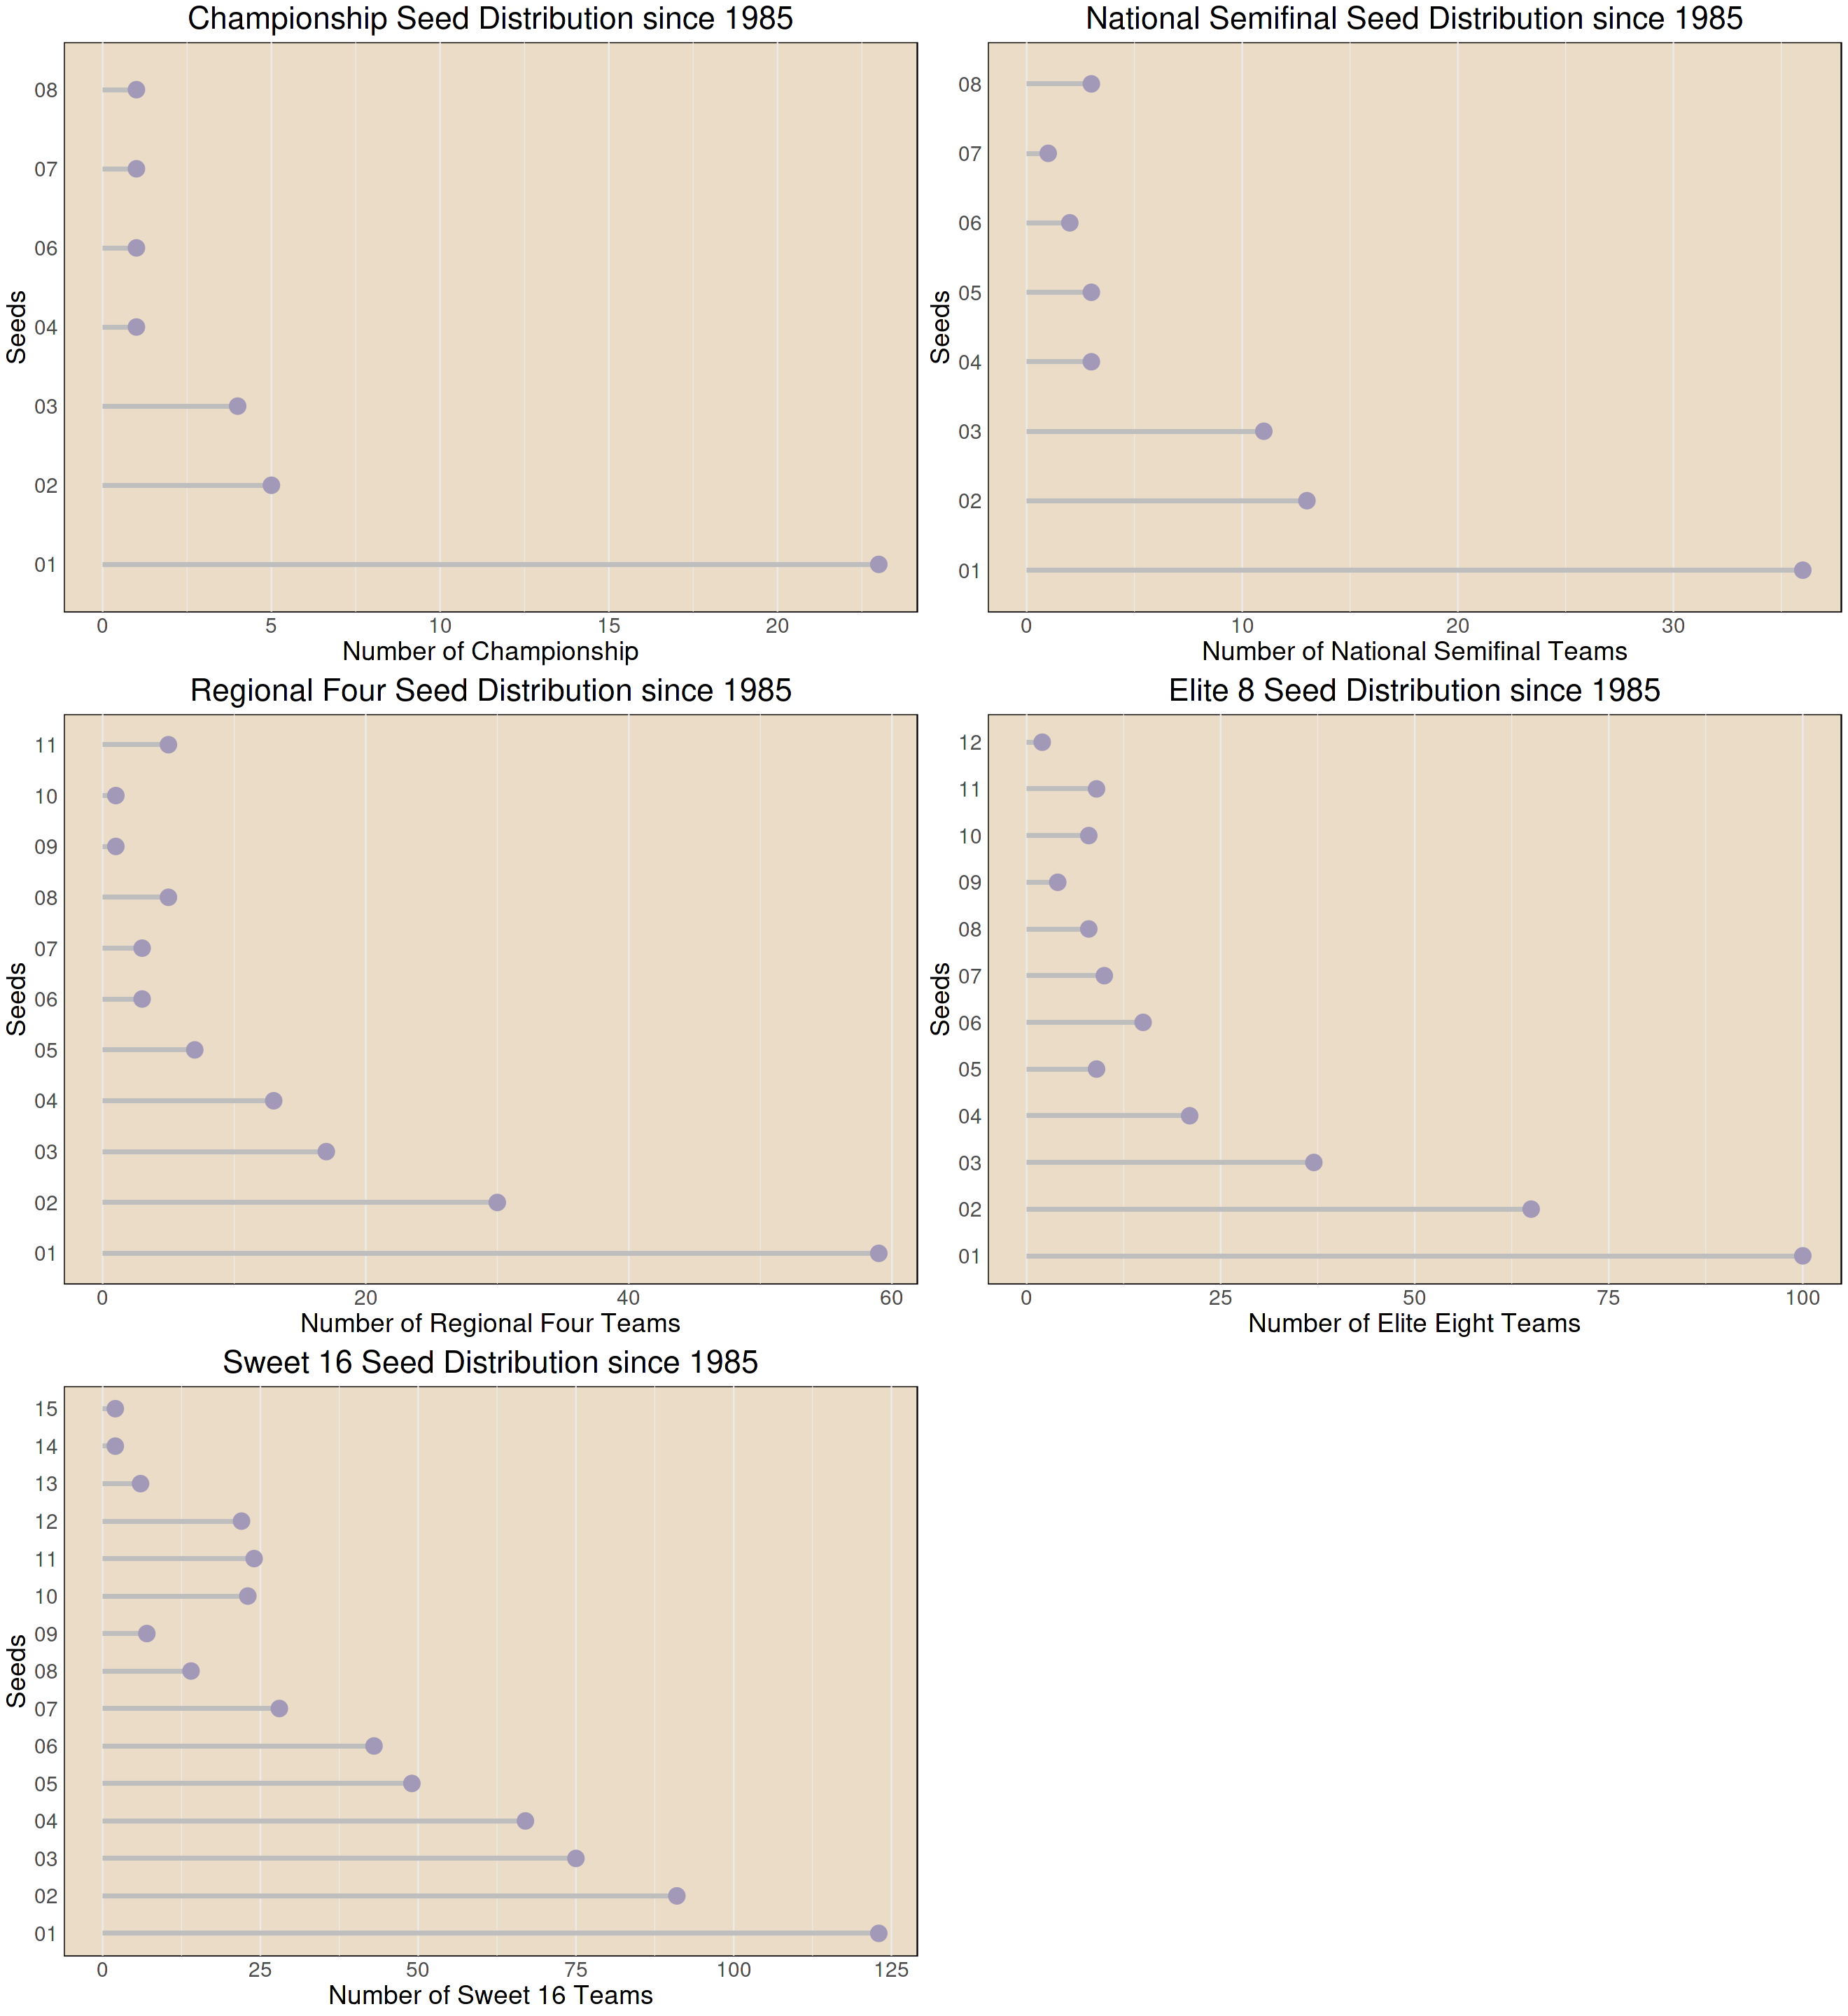

In [19]:
round_6_stats_plot<-round_6_stats %>% 
    group_by(Seed_num)%>%
    dplyr::summarise(n=n())

g0<-round_6_stats_plot%>% ggplot(aes(x=Seed_num,y=n)) +
    geom_segment( aes(x=Seed_num,xend=Seed_num, y=0, yend=n),size=1.5, color="grey") +
    geom_point(size=6, color="#a298b8") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Championship Seed Distribution since 1985", x= "Seeds", y= "Number of Championship")+
    coord_flip()

round_5_stats_plot<-round_5_stats %>% 
    group_by(Seed_num)%>%
    dplyr::summarise(n=n())

g1<-round_5_stats_plot%>% ggplot(aes(x=Seed_num,y=n)) +
    geom_segment( aes(x=Seed_num,xend=Seed_num, y=0, yend=n), size=1.5,color="grey") +
    geom_point(size=6, color="#a298b8") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "National Semifinal Seed Distribution since 1985", x= "Seeds", y= "Number of National Semifinal Teams")+
    coord_flip()

round_4_stats_plot<-round_4_stats %>% 
    group_by(Seed_num)%>%
    dplyr::summarise(n=n())

g2<-round_4_stats_plot%>% ggplot(aes(x=Seed_num,y=n)) +
    geom_segment( aes(x=Seed_num,xend=Seed_num, y=0, yend=n), size=1.5,color="grey") +
    geom_point(size=6, color="#a298b8") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Regional Four Seed Distribution since 1985", x= "Seeds", y= "Number of Regional Four Teams")+
    coord_flip()
options(repr.plot.width=12, repr.plot.height=6)

round_3_stats_plot<-round_3_stats %>% 
    group_by(Seed_num)%>%
    dplyr::summarise(n=n())

g3<-round_3_stats_plot%>% ggplot(aes(x=Seed_num,y=n)) +
    geom_segment( aes(x=Seed_num,xend=Seed_num, y=0, yend=n), size=1.5,color="grey") +
    geom_point(size=6, color="#a298b8") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Elite 8 Seed Distribution since 1985", x= "Seeds", y= "Number of Elite Eight Teams")+
    coord_flip()
round_2_stats_plot<-round_2_stats %>% 
    group_by(Seed_num)%>%
    dplyr::summarise(n=n())

g4<-round_2_stats_plot%>% ggplot(aes(x=Seed_num,y=n)) +
    geom_segment( aes(x=Seed_num,xend=Seed_num, y=0, yend=n),size=1.5, color="grey") +
    geom_point(size=6, color="#a298b8") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Sweet 16 Seed Distribution since 1985", x= "Seeds", y= "Number of Sweet 16 Teams")+
    coord_flip()

options(repr.plot.width=22, repr.plot.height=24)

grid.arrange(g0,g1,g2,g3,g4,ncol=2)

It looks like that Seed No.1 have won the most championship since 1985. So which teams have been given seed number No.1. 

In [20]:
round_0_stats_plot<-round_0_stats %>% 
    group_by(Seed_num, WTeamName)
round_0_stats_plot<-subset(round_0_stats_plot,Seed_num=='01')%>%
     group_by(WTeamName)%>%
    dplyr::summarise(n=n())

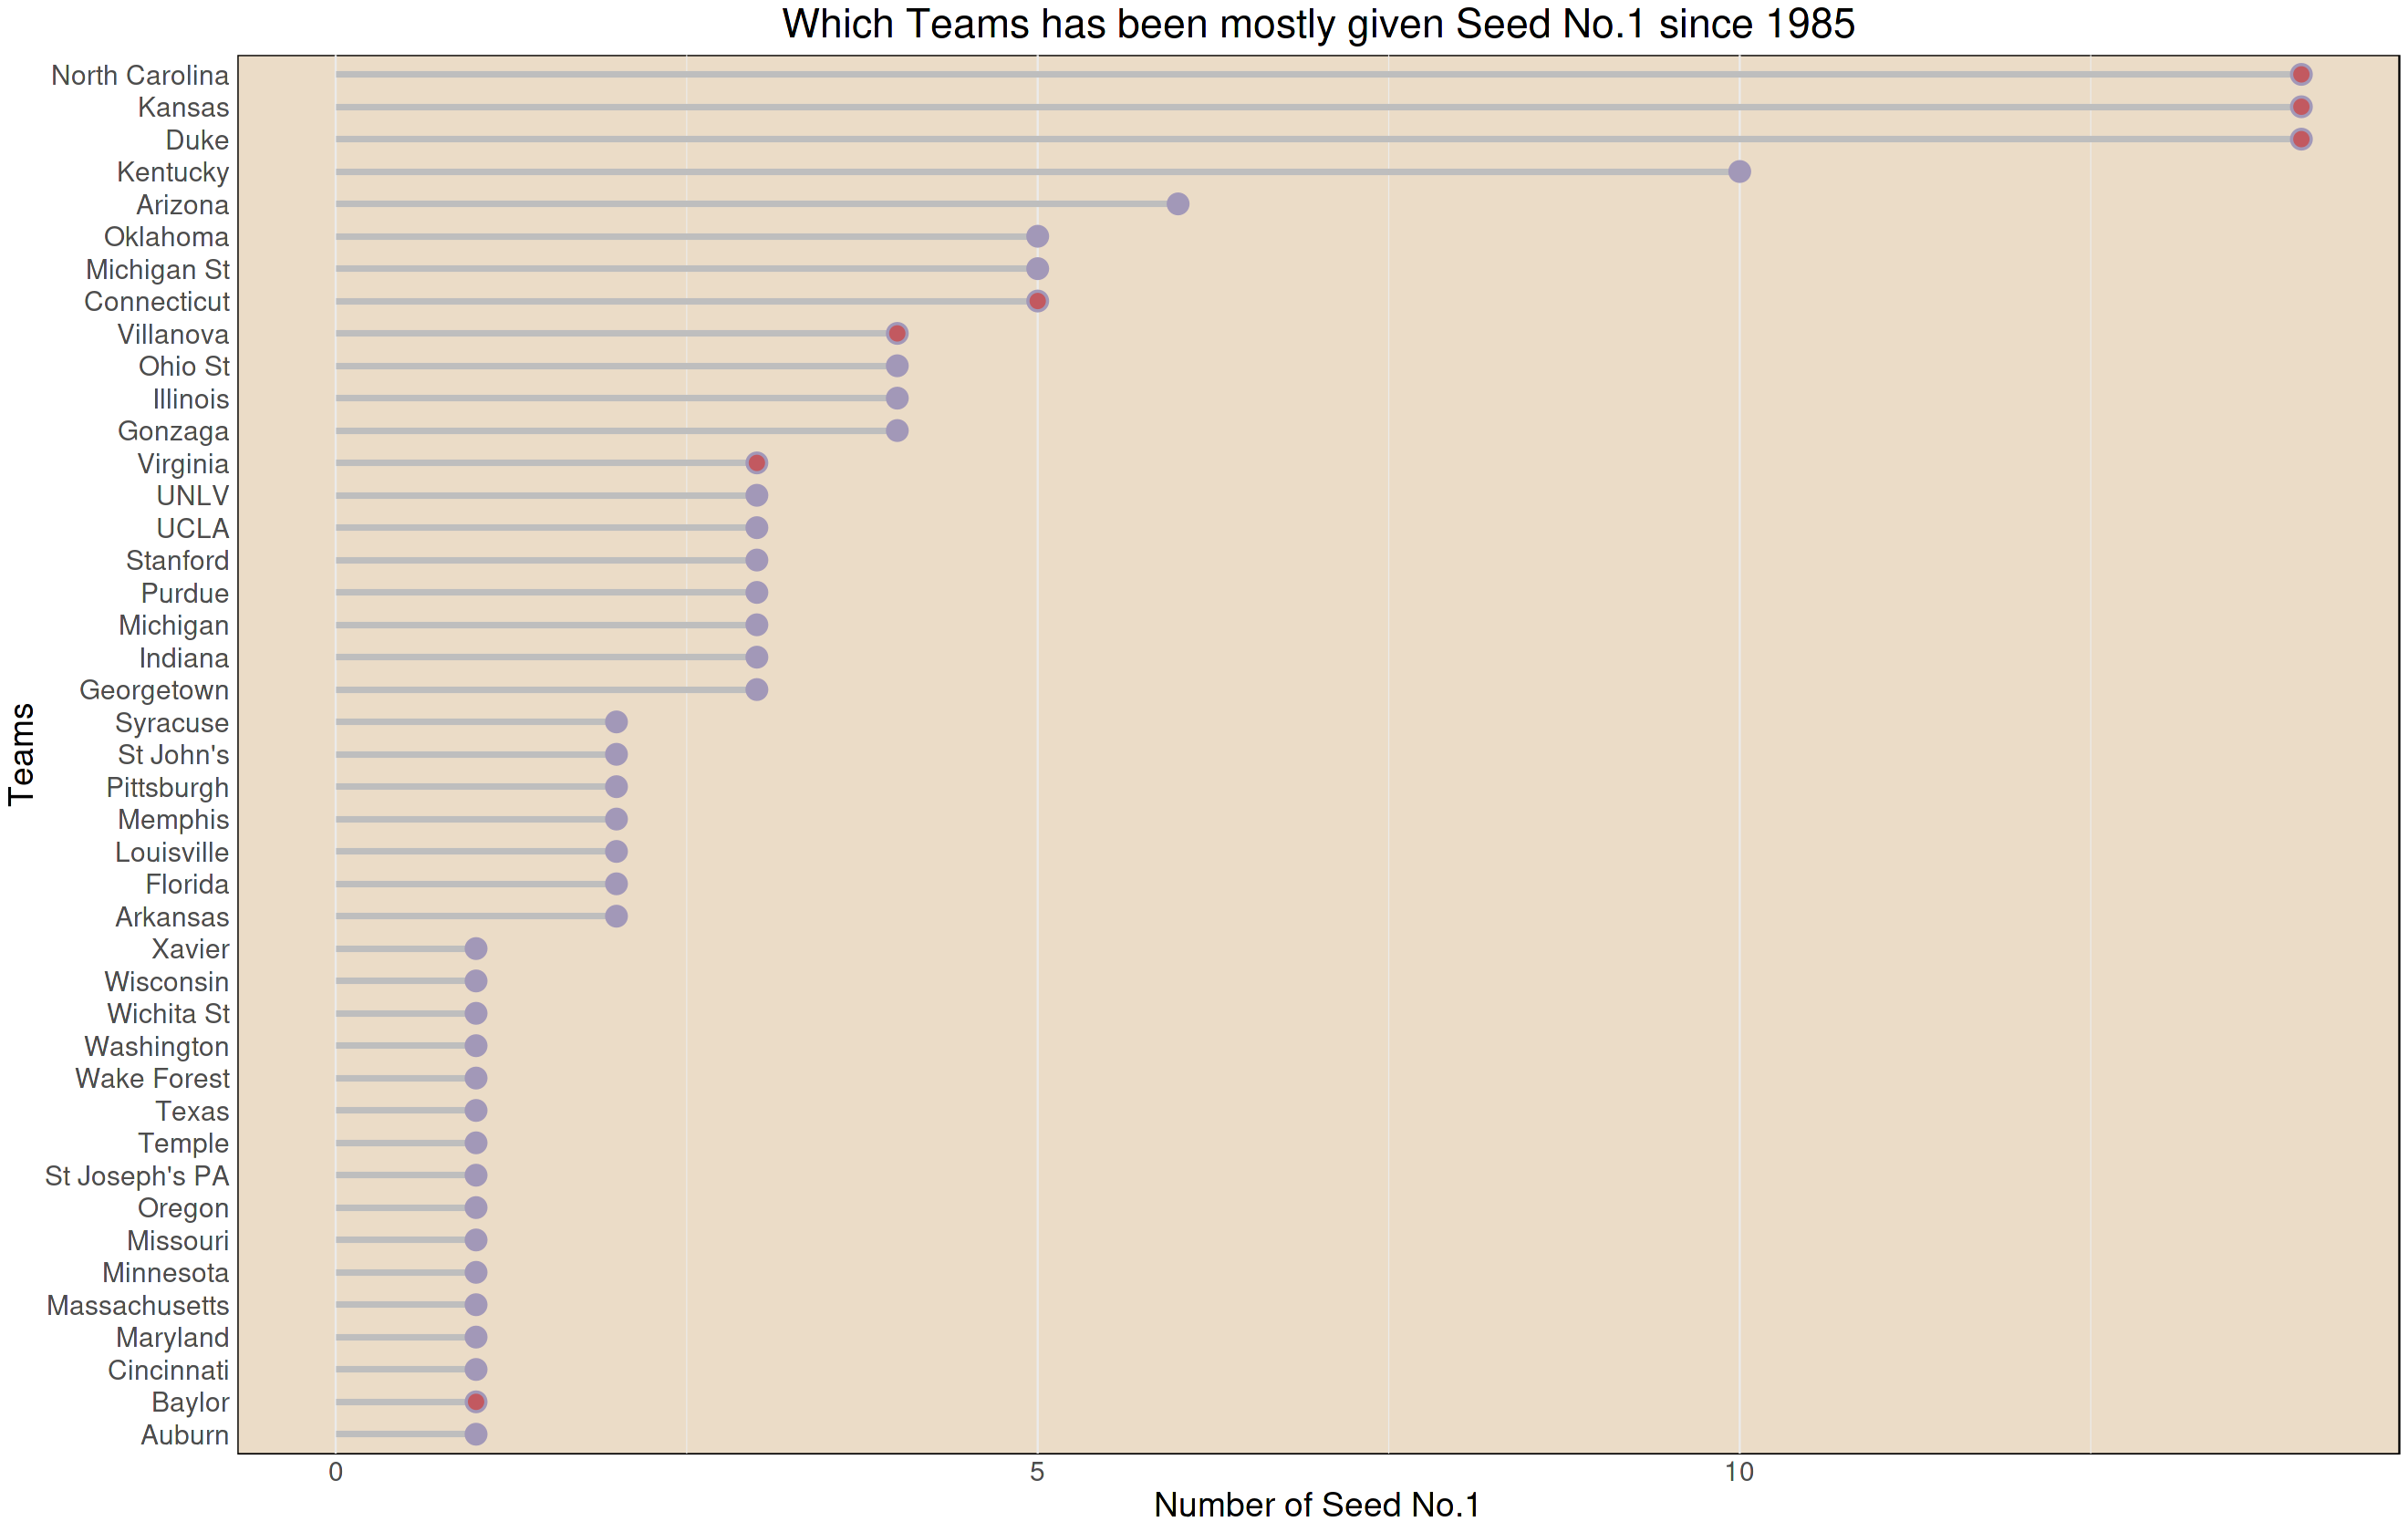

In [21]:
options(repr.plot.width=22, repr.plot.height=14)

highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kansas','Virginia','Baylor')
highlight_team<-subset(round_0_stats_plot,WTeamName %in% highlight_list)

round_0_stats_plot%>% ggplot(aes(x=reorder(WTeamName,n),y=n)) +
    geom_segment( aes(x=reorder(WTeamName,n),xend=reorder(WTeamName,n), y=0, yend=n),size=1.5, color="grey") +
    geom_point(size=6, color="#a298b8") +
    geom_point(data=highlight_team,size=4, color="#c25960") +
    theme_minimal()+
    theme(text = element_text(size = 22),
          panel.background = element_rect(fill="#ebdcc7"),
          plot.title = element_text(hjust = 0.5),
          panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank(),
      legend.position="none"
)+
    labs(title = "Which Teams has been mostly given Seed No.1 since 1985", x= "Teams", y= "Number of Seed No.1")+
    coord_flip()


#### Let's use Bump Chart to explore my ROI teams' performance spanning the seasons .

In [22]:
highlight_list<-c("Duke","North Carolina","Connecticut",'Villanova','Kansas','Virginia','Baylor')
round_0_stats_plot<-round_0_stats %>% 
    group_by(Season, WTeamName)
round_0_stats_plot<-subset(round_0_stats_plot,WTeamName%in%highlight_list)%>%
                mutate(seed_num = ifelse(Seed_num=="01",1,
                  ifelse(Seed_num=="02",2,
                  ifelse(Seed_num=="03",3,
                  ifelse(Seed_num=="04",4,
                  ifelse(Seed_num=="05",5,
                  ifelse(Seed_num=="06",6,
                  ifelse(Seed_num=="07",7,
                  ifelse(Seed_num=="08",8,
                  ifelse(Seed_num=="09",9,
                  ifelse(Seed_num=="10",10,
                  ifelse(Seed_num=="11",11,
                  ifelse(Seed_num=="12",12,
                  ifelse(Seed_num=="13",13,
                  ifelse(Seed_num=="14",14,
                  ifelse(Seed_num=="15",15,16))))))))))))))))

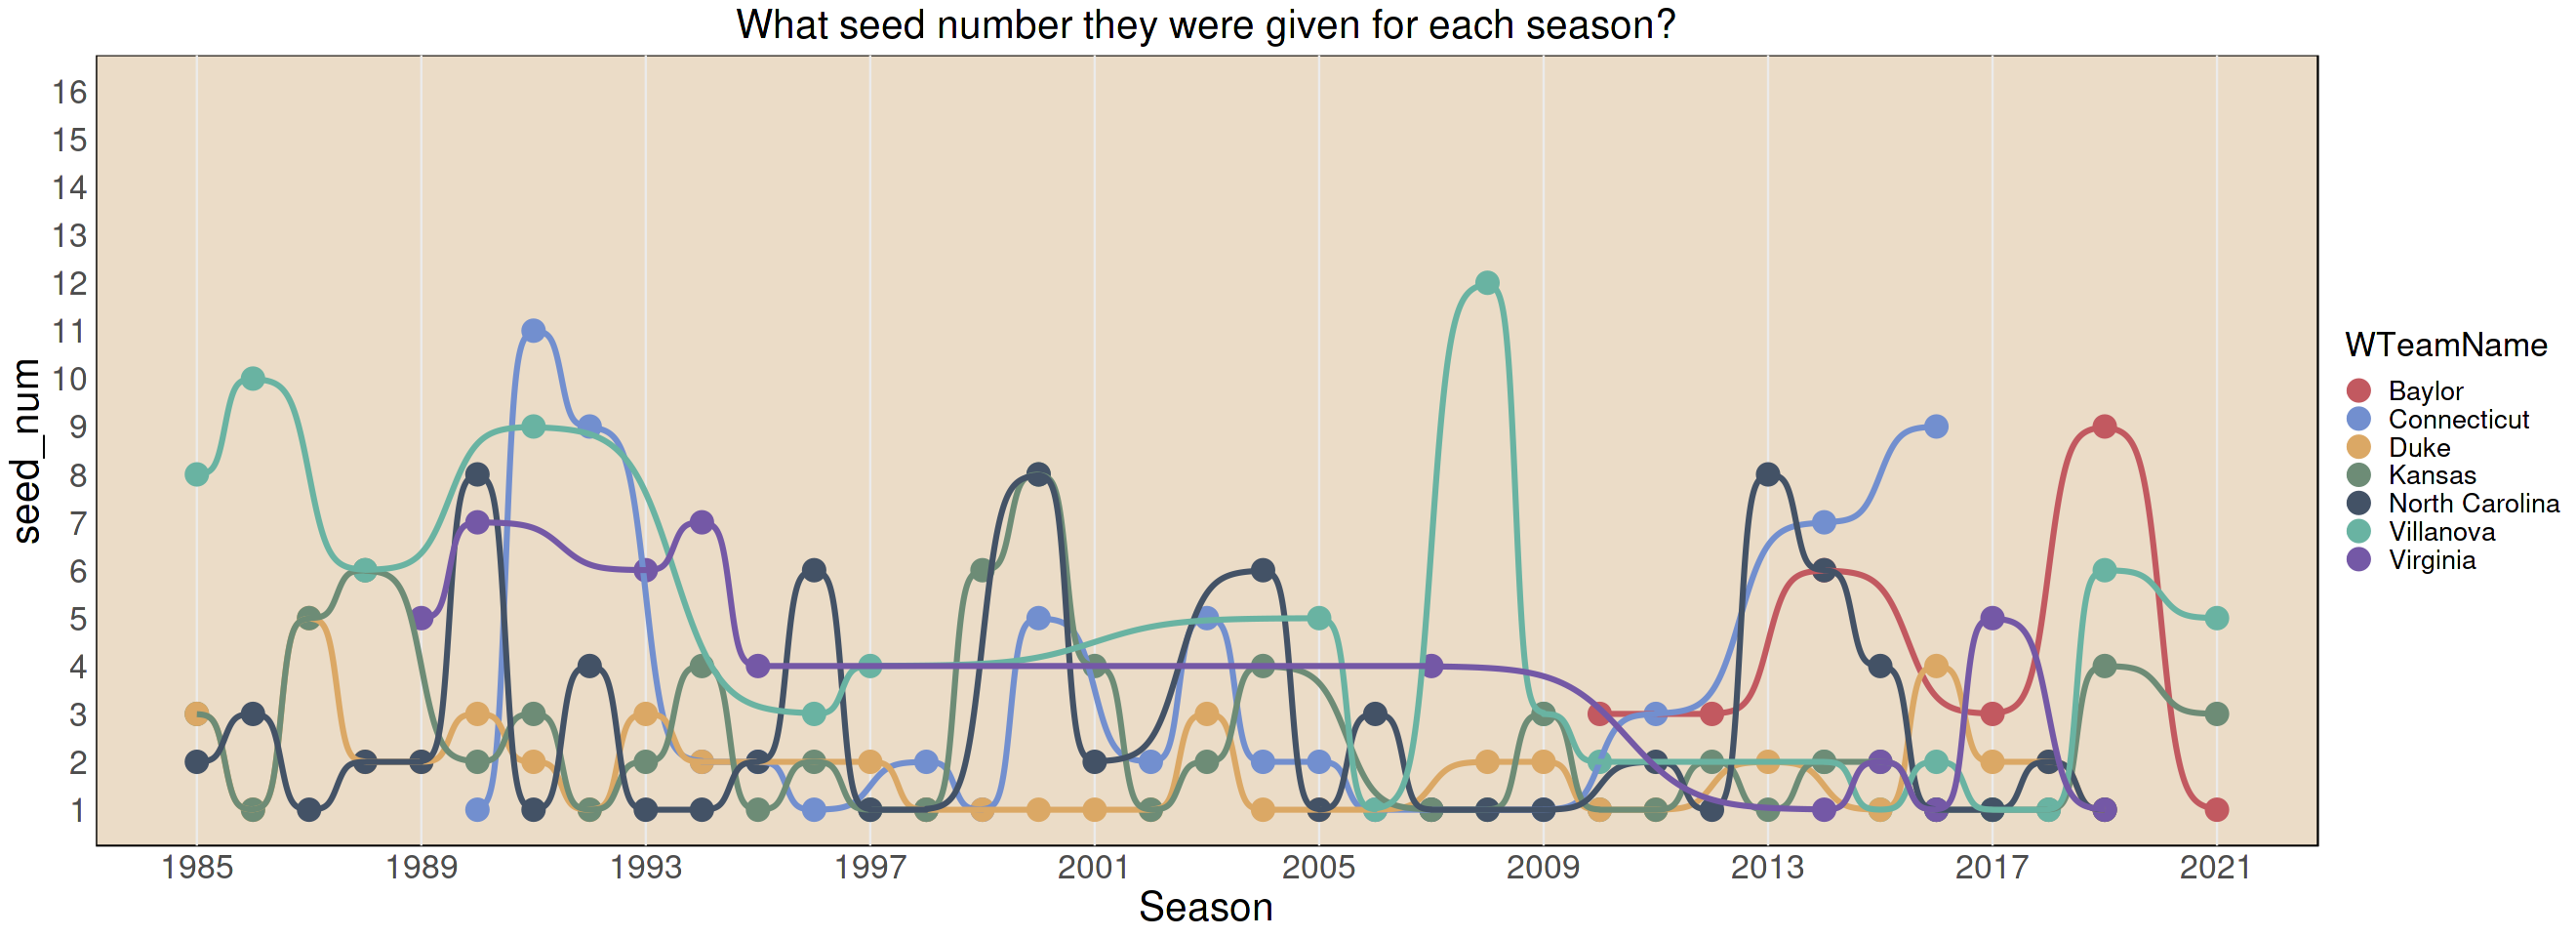

In [23]:
options(repr.plot.width=22, repr.plot.height=8)
ggplot(round_0_stats_plot, aes(Season, seed_num, color = WTeamName)) +
    geom_point(size = 6) +
    geom_bump(size = 1.3, smooth = 6)+
    scale_x_continuous(limits = c(1985, 2021),
                        breaks = seq(1985, 2021, 4)) +
    scale_y_continuous(limits = c(1,16),
                        breaks = seq(1, 16, 1)) +
    theme_minimal()+
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5),
          panel.background = element_rect(fill="#ebdcc7"),
          axis.text=element_text(size=20),
          axis.title=element_text(size=24),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.y = element_blank()
          )+
    labs(title = "What seed number they were given for each season?")+
scale_color_manual(values = c("#c25960","#728fcf","#dba865","#6d8c76","#435266","#69b3a2","#7458a6"))

## Data Section 2 - Team Box Scores

In [24]:
# read Data Section 2 files
# ----------------------------------------
# team-level box scores for NCAA tournaments since '2003' season.
tourney_stats <-read.csv(paste0(PATH,'MNCAATourneyDetailedResults.csv'),stringsAsFactors=FALSE)
# team-level box scores for regular seasons since '2003' season
regular_stats<-read.csv(paste0(PATH,'MRegularSeasonDetailedResults.csv'),stringsAsFactors=FALSE)

## Data Section 3 - Geograph

In [25]:
# read Data Section 3 files
# ----------------------------------------
# Games along with the city that the game was played in since 2010
game_cities<-read.csv(paste0(PATH,"MGameCities.csv"),stringsAsFactors = FALSE)
# A list of cities that have been locations for games played
cities<-read.csv(paste0(PATH,'Cities.csv'),stringsAsFactors=FALSE)

## Data Section 4 - Public Rankings

In [26]:
# Read Data Section 4 files
# ----------------------------------------
# weekly team rankings for top rating systems since 2002-2003 season
rank<-read.csv(paste0(PATH,"MMasseyOrdinals.csv"),stringsAsFactors = FALSE)

## Data Section 5 - Supplements

In [27]:
# Read Data Section 5 files
# ----------------------------------------
# Head coach for each team in each season 
coaches<-read.csv(paste0(PATH,"MTeamCoaches.csv"),stringsAsFactors = FALSE)
# Division I conferences since 1985
conf<-read.csv(paste0(PATH,'Conferences.csv'),stringsAsFactors=FALSE)
# conference affliations for each team during each season
team_conf<-read.csv(paste0(PATH,"MTeamConferences.csv"),stringsAsFactors = FALSE)
# list of games were part of post-season conference tournaments since 2001
conf_tourney<-read.csv(paste0(PATH,'MConferenceTourneyGames.csv'),stringsAsFactors=FALSE)
# thams that participated in post-season tournaments other than the NCAA tournament
secondary_tourney_team<-read.csv(paste0(PATH,"MSecondaryTourneyTeams.csv"),stringsAsFactors = FALSE)
# the final scores for the tournament game of 'secondary' post-season tournaments
secondary_tourney_compact_result<-read.csv(paste0(PATH,'MSecondaryTourneyCompactResults.csv'),stringsAsFactors= FALSE)
# alternative spellings for many team names ( help to relate the external data)
team_spell<-read.csv(paste0(PATH,'MTeamSpellings.csv'),stringsAsFactors=FALSE)
# the mechanism of teams pairs by using seeds
tourney_slots<-read.csv(paste0(PATH,'MNCAATourneySlots.csv'),stringsAsFactors=FALSE)
# represent the bracket structure in any given year
tourney_seeds_round_slots<-read.csv(paste0(PATH,'MNCAATourneySeedRoundSlots.csv'),stringsAsFactors=FALSE)